# Installing Python required libraries

In [1]:
!pip uninstall h5py
!pip install h5py==2.10.0

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/h5py-3.1.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libaec-9c9e97eb.so.0.0.10
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5-00e8fae8.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libhdf5_hl-383c339f.so.200.0.0
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libsz-e7aa62f5.so.2.0.1
    /usr/local/lib/python3.8/dist-packages/h5py.libs/libz-eb09ad1d.so.1.2.3
    /usr/local/lib/python3.8/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 14.8 MB/s 


In [2]:
!pip uninstall  seaborn --yes
!pip install  seaborn==0.10.1 scipy==1.5.2
!pip install wfdb==3.1.1

Found existing installation: seaborn 0.11.2
Uninstalling seaborn-0.11.2:
  Successfully uninstalled seaborn-0.11.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 215 kB 14.6 MB/s 
     |████████████████████████████████| 25.7 MB 79.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.4.0 requires scipy>=1.6, but you have scipy 1.5.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 9.9 MB/s 
     |████████████████████████████████| 7.6 MB 4.1 MB/s 
     |████████████████████████████████| 15

# Data download from PhysioNet servers. Then extract signals to data folder

In [ ]:
! rm -r *
!ls
!wget https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip 
!wget https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
!ls
print('Downloading data: Done')

!mkdir data
!unzip qt-database-1.0.0.zip >> /dev/null
!unzip mit-bih-noise-stress-test-database-1.0.0.zip >> /dev/null
!mv qt-database-1.0.0 data/
!mv mit-bih-noise-stress-test-database-1.0.0 data/
!rm qt-database-1.0.0.zip
!rm mit-bih-noise-stress-test-database-1.0.0.zip
!ls
!ls data
print('Extracting data: Done')

--2022-12-24 19:25:12--  https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87119682 (83M) [application/zip]
Saving to: ‘qt-database-1.0.0.zip’

qt-database-1.0.0.z 100%[===================>]  83.08M  1.83MB/s    in 28s     

2022-12-24 19:25:41 (3.00 MB/s) - ‘qt-database-1.0.0.zip’ saved [87119682/87119682]

--2022-12-24 19:25:41--  https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70945297 (68M) [application/zip]
Saving to: ‘mit-bih-noise-stress-test-database-1.0.0.zip’

mit-bih-noise-stres 100%[===================>]  67.66M  4.16MB/s    in 18s     

# Preprocessing ECG data

In [ ]:
import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle

QTpath='data/qt-database-1.0.0/'
newFs = 360

# Preprocessing signals
namesPath = glob.glob(QTpath + "/*.dat")
QTDatabaseSignals = dict()

register_name = None
for i in namesPath:

    # reading signals
    aux = i.split('.dat')
    register_name = aux[0].split('/')[-1]
    signal, fields = wfdb.rdsamp(aux[0])
    qu = len(signal)

    # reading annotations
    ann = wfdb.rdann(aux[0], 'pu1')
    anntype = ann.symbol
    annSamples = ann.sample

    # Obtaining P wave start positions
    Anntype = np.array(anntype)
    idx = Anntype == 'p'
    Pidx = annSamples[idx]
    idxS = Anntype == '('
    Sidx = annSamples[idxS]
    idxR = Anntype == 'N'
    Ridx = annSamples[idxR]

    ind = np.zeros(len(Pidx))

    for j in range(len(Pidx)):
        arr = np.where(Pidx[j] > Sidx)
        arr = arr[0]
        ind[j] = arr[-1]

    ind = ind.astype(np.int64)
    Pstart = Sidx[ind]

    # Shift 40ms before P wave start
    Pstart = Pstart - int(0.04*fields['fs'])

    # Extract first channel
    auxSig = signal[0:qu, 0]

    # Beats separation and removing outliers
    beats = list()
    for k in range(len(Pstart)-1):
        remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k+1])
        if np.sum(remove) < 2:
            beats.append(auxSig[Pstart[k]:Pstart[k+1]])

    # Creating the list that will contain each beat per signal
    beatsRe = list()

    # processing each beat
    for k in range(len(beats)):
        L = math.ceil(len(beats[k])*newFs/fields['fs'])
        normBeat = list(reversed(beats[k])) + list(beats[k]) + list(reversed(beats[k]))
        res = resample_poly(normBeat, newFs, fields['fs'])
        res = res[L-1:2*L-1]
        beatsRe.append(res)
    QTDatabaseSignals[register_name] = beatsRe

# Save Data
with open('data/QTDatabase.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(QTDatabaseSignals, output)
print('=========================================================')
print('MIT QT database saved as pickle file')

MIT QT database saved as pickle file


# Preprocessing Noise

In [ ]:
import numpy as np
import wfdb
import _pickle as pickle

# here can change the noise signal names bw,em , 118e_6
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/bw'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseBWL', signals)
with open('data/NoiseBWL.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')


fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['MLII', 'V1']
comments ["Created by `nst' from records 118 and em (SNR = -6 dB)"]
MIT BIH data noise stress test database (NSTDB) saved as pickle


# DL Datasets pereparation

In [ ]:
import numpy as np
import _pickle as pickle

print('Getting the Data ready ... ')

# The seed is used to ensure the ECG always have the same contamination level
# this enhance reproducibility
seed = 1234
np.random.seed(seed=seed)

# Load QT Database
with open('data/QTDatabase.pkl', 'rb') as input:
    # dict {register_name: beats_list}
    qtdb = pickle.load(input)

# Load NSTDB
with open('data/NoiseBWL.pkl', 'rb') as input:
    nstd = pickle.load(input)
# NSTDB
noise_channel1 = nstd[:, 0]
noise_channel2 = nstd[:, 1]
# Data split
noise_test = np.concatenate(
    (noise_channel1[0:int(noise_channel1.shape[0] * 0.13)], noise_channel2[0:int(noise_channel2.shape[0] * 0.13)]))
noise_train = np.concatenate((noise_channel1[int(noise_channel1.shape[0] * 0.13):-1],
                              noise_channel2[int(noise_channel2.shape[0] * 0.13):-1]))
# QTDatabase
beats_train = []
beats_test = []
test_set = ['sel123',  'sel233',  'sel302',  'sel307', 'sel820',  'sel853',   'sel16420', 'sel16795', 'sele0106',  'sele0121', 'sel32','sel49', 'sel14046', 'sel15814' ]


skip_beats = 0
samples = 512
qtdb_keys = list(qtdb.keys())

for i in range(len(qtdb_keys)):
    signal_name = qtdb_keys[i]

    for b in qtdb[signal_name]:

        b_np = np.zeros(samples)
        b_sq = np.array(b)
        init_padding = 16
        if b_sq.shape[0] > (samples - init_padding):
            skip_beats += 1
            continue

        b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

        if signal_name in test_set:
            beats_test.append(b_np)
        else:
            beats_train.append(b_np)

# Noise was added in a proportion from 0.2 to 2 times the ECG signal amplitude
sn_train = []
sn_test = []

noise_index = 0

# Adding noise to train
rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
for i in range(len(beats_train)):
    noise = noise_train[noise_index:noise_index + samples]
    beat_max_value = np.max(beats_train[i]) - np.min(beats_train[i])
    noise_max_value = np.max(noise) - np.min(noise)
    Ase = noise_max_value / beat_max_value
    alpha = rnd_train[i] / Ase
    signal_noise = beats_train[i] + alpha * noise
    sn_train.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_train) - samples):
        noise_index = 0

# Adding noise to test
noise_index = 0
rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
for i in range(len(beats_test)):
    noise = noise_test[noise_index:noise_index + samples]
    beat_max_value = np.max(beats_test[i]) - np.min(beats_test[i])
    noise_max_value = np.max(noise) - np.min(noise)
    Ase = noise_max_value / beat_max_value
    alpha = rnd_test[i] / Ase
    signal_noise = beats_test[i] + alpha * noise
    sn_test.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_test) - samples):
        noise_index = 0

X_train = np.array(sn_train)
y_train = np.array(beats_train)

X_test = np.array(sn_test)
y_test = np.array(beats_test)

X_train = np.expand_dims(X_train, axis=2)
y_train = np.expand_dims(y_train, axis=2)

X_test = np.expand_dims(X_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

Dataset = [X_train, y_train, X_test, y_test]

print('Dataset ready to use.')

Getting the Data ready ... 
Dataset ready to use.


# Define Metric functions

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)  # axis 1 is the signal dimension


def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1) # axis 1 is the signal dimension


def PRD(y, y_pred):
    N = np.sum(np.square(y_pred - y), axis=1)
    D = np.sum(np.square(y_pred - np.mean(y)), axis=1)

    PRD = np.sqrt(N/D) * 100

    return PRD


def COS_SIM(y, y_pred):
    cos_sim = []

    y = np.squeeze(y, axis=-1)
    y_pred = np.squeeze(y_pred, axis=-1)

    for idx in range(len(y)):
        kl_temp = cosine_similarity(y[idx].reshape(1, -1), y_pred[idx].reshape(1, -1))
        cos_sim.append(kl_temp)

    cos_sim = np.array(cos_sim)
    return cos_sim

# Visualization functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:   # metric_values[metric][model][beat]
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

def generate_table_time(column_names, all_values, Exp_names, gpu=True):
    all_values[0] = all_values[0][-2::] + all_values[0][0:-2]
    all_values[1] = all_values[1][-2::] + all_values[1][0:-2]

    print('\n')

    tb = PrettyTable()
    ind = 0

    if gpu:
        device = 'GPU'
    else:
        device = 'CPU'

    for exp_name in Exp_names:
        tb.field_names = ['Method/Model'] + [column_names[0] + '(' + device + ') h:m:s:ms'] + [
            column_names[1] + '(' + device + ') h:m:s:ms']

        tb_row = []
        tb_row.append(exp_name)
        tb_row.append(all_values[0][ind])
        tb_row.append(all_values[1][ind])

        tb.add_row(tb_row)

        ind += 1

    print(tb)

    if gpu:
        print('* For FIR and IIR Filters is CPU since scipy filters are CPU based implementations')

def generate_hboxplot(np_data, description, ylabel, log, set_x_axis_size=None):
    # Process the results and store in Panda objects
    col = description
    loss_val_np = np.rot90(np_data)

    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure
    sns.set(style="whitegrid")

    f, ax = plt.subplots(figsize=(15, 6))

    ax = sns.boxplot(data=pd_df, orient="h", width=0.4)

    if log:
        ax.set_xscale("log")

    if set_x_axis_size != None:
        ax.set_xlim(set_x_axis_size)

    ax.set(ylabel='Models/Methods', xlabel=ylabel)
    ax = sns.despine(left=True, bottom=True)

    plt.show()


def ecg_view(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg_blw, 'k', label='ECG with noise')
    plt.plot(ecg, 'g', label='ECG orig')
    plt.plot(ecg_dl, 'b', label= 'ECG Improved FCN-DAE Filtered')
    plt.plot(ecg_f, 'r', label= 'ECG ِ Improved DRNN Filtered')
    plt.grid(True)

    plt.ylabel('au')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

def ecg_view_diff(ecg, ecg_blw, ecg_dl, ecg_f, signal_name=None, beat_no=None):

    fig, ax = plt.subplots(figsize=(16, 9))
    plt.plot(ecg, 'g', label='ECG orig')
    # plt.plot(ecg_dl, 'b', label='ECG DL Filtered')
    # plt.plot(ecg_f, 'r', label='ECG IIR Filtered')
    plt.plot(ecg - ecg_dl, color='#0099ff', lw=3, label='Difference ECG -  Improved FCN-DAE')
    plt.plot(ecg - ecg_f, color='#cb828d', lw=3, label='Difference ECG - Improved DRNN Filter')
    plt.grid(True)

    plt.ylabel('Amplitude (au)')
    plt.xlabel('samples')

    leg = ax.legend()

    if signal_name != None and beat_no != None:
        plt.title('Signal ' + str(signal_name) + 'beat ' + str(beat_no))
    else:
        plt.title('ECG signal for comparison')

    plt.show()

# Classic digital Filters

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import kaiserord, firwin, filtfilt, butter


def FIRRemoveBL(ecgy, Fs, Fc, factor):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0
    
    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate. 
    width = 0.07/nyq_rate 
    
    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20*np.log10(0.001))+1
    ripple_db = ripple_db / factor

    
    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)
       
    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc/nyq_rate, window=('kaiser', beta), pass_zero='highpass')

    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)
    
    return ECG_Clean, N


def FIRRemoveHF(ecgy, Fs, Fc, factor):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # The Nyquist rate of the signal.
    nyq_rate = Fs / 2.0

    # The desired width of the transition from stop to pass,
    # relative to the Nyquist rate.
    width = 0.07 / nyq_rate

    # Attenuation in the stop band, in dB.
    # related to devs in Matlab. On Matlab is on proportion
    ripple_db = round(-20 * np.log10(0.001)) + 1
    ripple_db = ripple_db / factor

    # Compute the order and Kaiser parameter for the FIR filter.
    N, beta = kaiserord(ripple_db, width)

    # Use firwin with a Kaiser window to create a highpass FIR filter.
    h = firwin(N, Fc / nyq_rate, window=('kaiser', beta), pass_zero='lowpass')

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(h, 1.0, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
    else:
        ECG_Clean = filtfilt(h, 1.0, ecgy)

    return ECG_Clean, N

def IIRRemoveBL(ecgy,Fs, Fc):
    
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW
    
    # getting the length of the signal
    signal_len = len(ecgy)
    
    # fixed order
    N = 4
    
    # Normalized Cutt of frequency
    Wn = Fc/(Fs/2)    
    
    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'highpass', analog=False)
    
    # Check filtfilt condition
    if N*3 > signal_len:
        diff = N*3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))
        
        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]
        
    else:
        ECG_Clean = filtfilt(b, a, ecgy)
                   
    return ECG_Clean


def IIRRemoveHF(ecgy, Fs, Fc):
    #    ecgy:        the contamined signal (must be a list)
    #    Fc:          cut-off frequency
    #    Fs:          sample frequiency
    #    ECG_Clean :  processed signal without BLW

    # getting the length of the signal
    signal_len = len(ecgy)

    # fixed order
    N = 4

    # Normalized Cutt of frequency
    Wn = Fc / (Fs / 2)

    # IIR butterworth coefficients
    b, a = butter(N, Wn, 'lowpass', analog=False)

    # Check filtfilt condition
    if N * 3 > signal_len:
        diff = N * 3 - signal_len
        ecgy = list(reversed(ecgy)) + list(ecgy) + list(ecgy[-1] * np.ones(diff))

        # Filtering with filtfilt
        ECG_Clean = filtfilt(b, a, ecgy)
        ECG_Clean = ECG_Clean[signal_len: signal_len + signal_len]

    else:
        ECG_Clean = filtfilt(b, a, ecgy)

    return ECG_Clean


def FIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(FIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal, N = FIRRemoveBL(s, Fs, Fc_l, 4.5)
        temp_signal, N = FIRRemoveHF(temp_signal, Fs, Fc_h, 4.5)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]


def IIR_test_Dataset(Dataset):
    [train_set, train_set_GT, X_test, y_test] = Dataset

    ## parameters
    Fs = 360
    Fc_l = 0.67
    Fc_h = 150.0

    y_filter_out = []

    current_signal = 0

    for signal in X_test:
        current_signal += 1
        #print('(IIR) Filtering signal ' + str(current_signal) + ' of ' + str(len(X_test)))
        s = np.squeeze(signal, axis=1).tolist()

        temp_signal = IIRRemoveBL(s, Fs, Fc_l)
        temp_signal = IIRRemoveHF(temp_signal, Fs, Fc_h)

        y_filter_out.append(temp_signal)

    y_filter_out = np.expand_dims(np.array(y_filter_out), axis=2)

    return [X_test, y_test, y_filter_out]

# Deep Learning Models

In [ ]:
import keras
from keras.models import Sequential, Model
# from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Add, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding, AvgPool1D, LeakyReLU, MaxPooling1D
from keras.initializers import glorot_uniform
import keras.backend as K


def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    """
        https://stackoverflow.com/a/45788699

        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

def Improved_FCN_DAE():
    dropout_rate=0.002
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(input)

    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    # x = MaxPooling1D(pool_size=8, strides=1)(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

# added

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)


# added

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=40,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
# added

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)


# added

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model



def FCN_DAE():
    input_shape = (512, 1)
    input = Input(shape=input_shape)

    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(input)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=10,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)

    x = BatchNormalization()(x)
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=10,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model

def DRRN_denoising():
    model = Sequential()
    model.add(LSTM(64, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model


def LSTM_denoising():
    model = Sequential()
    model.add(LSTM(140, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(140, activation='relu'))
    model.add(LSTM(140, return_sequences=True))
    model.add(Dense(140, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

# Deep Learning Pipelines

In [ ]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split

# Custom loss SSD
def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)

# Combined loss SSD + MSE
def combined_ssd_mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-2) * 500 + K.sum(K.square(y_true - y_pred), axis=-2)

def combined_ssd_mad_loss(y_true, y_pred):
    return K.max(K.square(y_true - y_pred), axis=-2) * 50 + K.sum(K.square(y_true - y_pred), axis=-2)

# Custom loss SAD
def sad_loss(y_true, y_pred):
    return K.sum(K.sqrt(K.square(y_pred - y_true)), axis=-2)

# Custom loss MAD
def mad_loss(y_true, y_pred):
    return K.max(K.square(y_pred - y_true), axis=-2)


def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))

    [X_train, y_train, X_test, y_test] = Dataset

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

    # ==================
    # LOAD THE DL MODEL
    # ==================
    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    if experiment == 'Improved_FCN-DAE':
        # FCN_DAE
        model = Improved_FCN_DAE()
        model_label = 'Improved_FCN-DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'LSTM_denoising':
        model = LSTM_denoising()
        model_label = 'LSTM_denoising'

    print('\n ' + model_label + '\n ')

    model.summary()

    # epochs = int(1e5)  # 100000
    epochs = 1000
    batch_size = 128
    lr = 1e-3
    # lr = 1e-4
    minimum_lr = 1e-10


    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'LSTM_denoising':
        criterion = keras.losses.mean_squared_error

    elif experiment == 'FCN-DAE':
        criterion = ssd_loss

    elif experiment == 'Improved_FCN-DAE':
        criterion = ssd_loss

    else:
        criterion = combined_ssd_mad_loss


    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # Keras Callbacks

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'

    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',  # on acc has to go max
                                 save_weights_only=True)

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',  # on acc has to go max
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)

    early_stop = EarlyStopping(monitor="val_loss",  # "val_loss"
                               min_delta=0.005,
                               mode='min',  # on acc has to go max
                               patience=10,
                               verbose=1)

    tb_log_dir = './runs/' + model_label

    tboard = TensorBoard(log_dir=tb_log_dir, histogram_freq=0,
                         write_graph=False, write_grads=False,
                         write_images=False, embeddings_freq=0,
                         embeddings_layer_names=None,
                         embeddings_metadata=None)

    # To run the tensor board
    # tensorboard --logdir=./runs

    # GPU
    model.fit(x=X_train, y=y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[early_stop,
                         reduce_lr,
                         checkpoint,
                         tboard])

    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')

    [train_set, train_set_GT, X_test, y_test] = Dataset

    batch_size = 32

    # ==================
    # LOAD THE DL MODEL
    # ==================

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'

    
    if experiment == 'Improved_FCN-DAE':
        model = Improved_FCN_DAE()
        model_label = 'Improved_FCN-DAE'

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'

    if experiment == 'LSTM_denoising':
        
        model = LSTM_denoising()
        model_label = 'LSTM_denoising'

    print('\n ' + model_label + '\n ')

    model.summary()

    # Loss function selection according to method implementation
    if experiment == 'DRNN':
        criterion = 'mse'

    elif experiment == 'LSTM_denoising':
        criterion = 'mse'
    elif experiment == 'FCN-DAE':
        criterion = ssd_loss
    elif experiment == 'Improved_FCN-DAE':
        criterion = ssd_loss
    else:
        criterion = combined_ssd_mad_loss

    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=0.01),
                  metrics=[losses.mean_squared_error, losses.mean_absolute_error, ssd_loss, mad_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'
    # load weights
    model.load_weights(model_filepath)

    # Test score
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)


    K.clear_session()

    return [X_test, y_test, y_pred]

# Train models.

In [ ]:
import _pickle as pickle
from datetime import datetime
import numpy as np


dl_experiments = [
                  # 'DRNN',
                  'LSTM_denoising',
                  # 'FCN-DAE',
                  'Improved_FCN-DAE' ,
                  ]


train_time_list = []
test_time_list = []

for experiment in range(len(dl_experiments)):
    start_train = datetime.now()
    train_dl(Dataset, dl_experiments[experiment])
    end_train = datetime.now()
    train_time_list.append(end_train - start_train)

    start_test = datetime.now()
    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])
    end_test = datetime.now()
    test_time_list.append(end_test - start_test)

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(test_results, output)
    print('Results from experiment ' + dl_experiments[experiment] + ' saved')





Deep Learning pipeline: Training the model for exp LSTM_denoising

 LSTM_denoising
 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512, 140)          79520     
                                                                 
 dense (Dense)               (None, 512, 140)          19740     
                                                                 
 lstm_1 (LSTM)               (None, 512, 140)          157360    
                                                                 
 dense_1 (Dense)             (None, 512, 140)          19740     
                                                                 
 dense_2 (Dense)             (None, 512, 1)            141       
                                                                 
Total params: 276,501
Trainable params: 276,501
Non-trainable params: 0
_______________________________

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/1000
394/394 [==============================] - ETA: 0s - loss: 0.0620 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1129 - ssd_loss: 31.7406 - mad_loss: 1.9069
Epoch 1: val_loss improved from inf to 0.05809, saving model to LSTM_denoising_weights.best.hdf5
394/394 [==============================] - 57s 125ms/step - loss: 0.0620 - mean_squared_error: 0.0620 - mean_absolute_error: 0.1129 - ssd_loss: 31.7406 - mad_loss: 1.9069 - val_loss: 0.0581 - val_mean_squared_error: 0.0581 - val_mean_absolute_error: 0.1111 - val_ssd_loss: 29.7403 - val_mad_loss: 1.6542 - lr: 0.0010
Epoch 2/1000
394/394 [==============================] - ETA: 0s - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1045 - ssd_loss: 26.8602 - mad_loss: 1.3969
Epoch 2: val_loss improved from 0.05809 to 0.04115, saving model to LSTM_denoising_weights.best.hdf5
394/394 [==============================] - 46s 116ms/step - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1045

# Run experiments using Classic FIR and IIR filters

In [ ]:


# Classical Filters

# # FIR
# print('Running FIR fiter on the test set. This will take a while (2h)...')
# start_test = datetime.now()
# [X_test_f, y_test_f, y_filter] = FIR_test_Dataset(Dataset)
# end_test = datetime.now()
# train_time_list.append(0)
# test_time_list.append(end_test - start_test)

# test_results_FIR = [X_test_f, y_test_f, y_filter]

# # Save FIR filter results
# with open('test_results_FIR.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(test_results_FIR, output)
# print('Results from experiment FIR filter saved')

# # IIR
# print('Running IIR fiter on the test set. This will take a while (25 mins)...')
# start_test = datetime.now()
# [X_test_f, y_test_f, y_filter] = IIR_test_Dataset(Dataset)
# end_test = datetime.now()
# train_time_list.append(0)
# test_time_list.append(end_test - start_test)

# test_results_IIR = [X_test_f, y_test_f, y_filter]

# # Save IIR filter results
# with open('test_results_IIR.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(test_results_IIR, output)
# print('Results from experiment IIR filter saved')

# Saving timing list
timing = [train_time_list, test_time_list]
with open('timing.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(timing, output)
print('Timing saved')



NameError: ignored

# Run all metrics and plot results in tables

In [ ]:
####### LOAD EXPERIMENTS #######

# Load timing
# with open('timing.pkl', 'rb') as input:
#     timing = pickle.load(input)
#     [train_time_list, test_time_list] = timing

# Load Results DRNN
# with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
#     test_DRNN = pickle.load(input)

# Load Results FCN_DAE
# with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
#     test_FCN_DAE = pickle.load(input)

#Load Results Improved DRNN
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_LSTM_denoising = pickle.load(input)

# Load Results FCN_DAE
with open('test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_Improved_FCN_DAE = pickle.load(input)

# # Load Result FIR Filter
# with open('/content/runs/test_results_FIR.pkl', 'rb') as input:
#     test_FIR = pickle.load(input)

# # Load Result IIR Filter
# with open('/content/runs/test_results_IIR.pkl', 'rb') as input:
#     test_IIR = pickle.load(input)




####### Calculate Metrics #######

print('Calculating metrics for -06...')

# DL Metrics

# Exp DRNN

# [X_test, y_test, y_pred] = test_DRNN

# SSD_values_DL_DRNN = SSD(y_test, y_pred)

# MAD_values_DL_DRNN = MAD(y_test, y_pred)

# PRD_values_DL_DRNN = PRD(y_test, y_pred)

# COS_SIM_values_DL_DRNN = COS_SIM(y_test, y_pred)

# # Exp FCN-DAE

# [X_test, y_test, y_pred] = test_FCN_DAE

# SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)

# MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)

# PRD_values_DL_FCN_DAE = PRD(y_test, y_pred)

# COS_SIM_values_DL_FCN_DAE = COS_SIM(y_test, y_pred)

## Improved_FCN_DAE

[X_test, y_test, y_pred] = test_Improved_FCN_DAE

SSD_values_DL_Improved_FCN_DAE = SSD(y_test, y_pred)

MAD_values_DL_Improved_FCN_DAE = MAD(y_test, y_pred)

PRD_values_DL_Improved_FCN_DAE = PRD(y_test, y_pred)

COS_SIM_values_DL_Improved_FCN_DAE = COS_SIM(y_test, y_pred)


# # Exp Improved DRNN

[X_test, y_test, y_pred] = test_LSTM_denoising

SSD_values_DL_LSTM_denoising = SSD(y_test, y_pred)

MAD_values_DL_LSTM_denoising = MAD(y_test, y_pred)

PRD_values_DL_LSTM_denoising = PRD(y_test, y_pred)

COS_SIM_values_DL_LSTM_denoising = COS_SIM(y_test, y_pred)


####### Results Visualization #######


SSD_all = [
          #  SSD_values_FIR,
          #  SSD_values_IIR,
          #  SSD_values_DL_DRNN,    
          #  SSD_values_DL_FCN_DAE,
           SSD_values_DL_LSTM_denoising,
           SSD_values_DL_Improved_FCN_DAE,
            
           
           ]

MAD_all = [
          #  MAD_values_FIR,
          #  MAD_values_IIR,
          #  MAD_values_DL_DRNN, 
          #  MAD_values_DL_FCN_DAE,
            MAD_values_DL_LSTM_denoising,
           MAD_values_DL_Improved_FCN_DAE,
          
           ]

PRD_all = [
          #  PRD_values_FIR,
          #  PRD_values_IIR,
          #  PRD_values_DL_DRNN,
          #  PRD_values_DL_FCN_DAE,
           PRD_values_DL_LSTM_denoising,
           PRD_values_DL_Improved_FCN_DAE,
        
           ]

CORR_all = [
            # COS_SIM_values_FIR,
            # COS_SIM_values_IIR,
            # COS_SIM_values_DL_DRNN,
            # COS_SIM_values_DL_FCN_DAE,
            COS_SIM_values_DL_LSTM_denoising,
            COS_SIM_values_DL_Improved_FCN_DAE
            
            ]

# Exp_names =['FIR Filter', 'IIR Filter'] + dl_experiments 
Exp_names = dl_experiments 

metrics = ['SSD', 'MAD', 'PRD', 'COS_SIM']
metric_values = [SSD_all, MAD_all, PRD_all, CORR_all]

# Metrics table
generate_table(metrics, metric_values, Exp_names)

# Timing table
# timing_var = ['training', 'test']
# generate_table_time(timing_var, timing, Exp_names, gpu=True)

Calculating metrics for -06...


+------------------+----------------+---------------+-----------------+---------------+
|   Method/Model   |      SSD       |      MAD      |       PRD       |    COS_SIM    |
+------------------+----------------+---------------+-----------------+---------------+
|  LSTM_denoising  | 8.120 (11.851) | 0.535 (0.404) | 79.791 (61.712) | 0.827 (0.188) |
| Improved_FCN-DAE | 5.597 (7.974)  | 0.480 (0.361) | 63.430 (51.211) | 0.886 (0.113) |
+------------------+----------------+---------------+-----------------+---------------+


# Plot Graphs

SSD Metric comparative graph


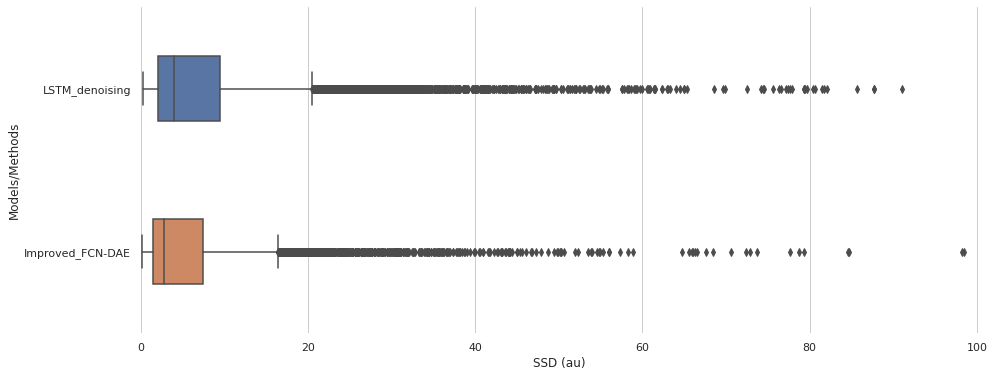

MAD Metric comparative graph


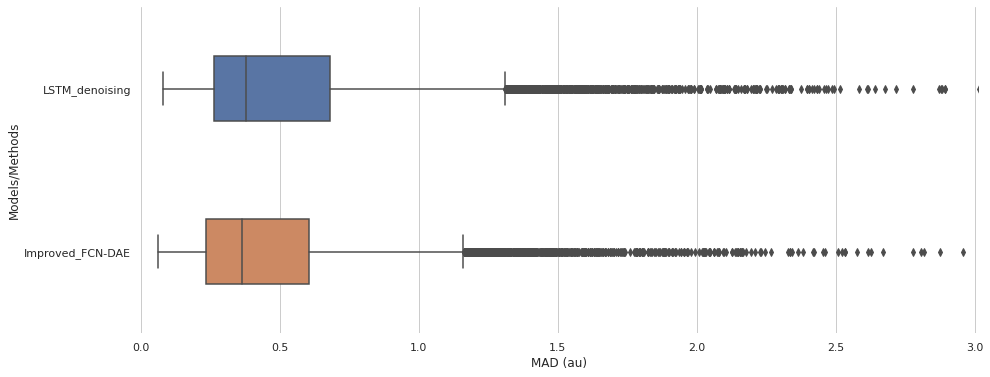

PRD Metric comparative graph


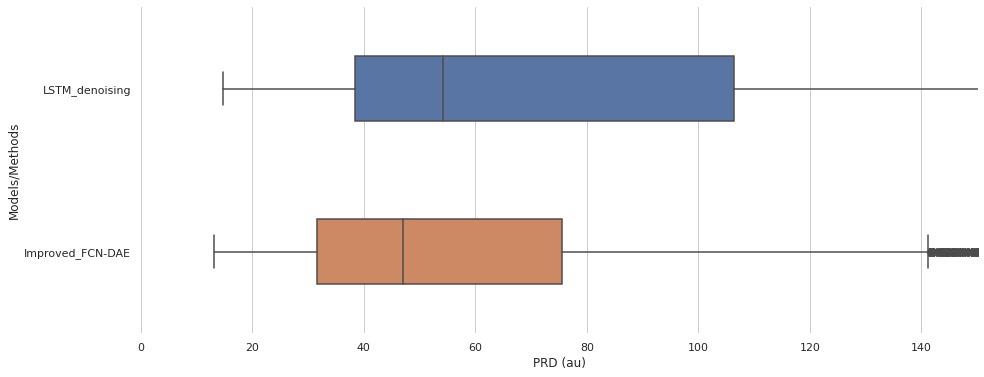

Cosine Similarity Metric comparative graph


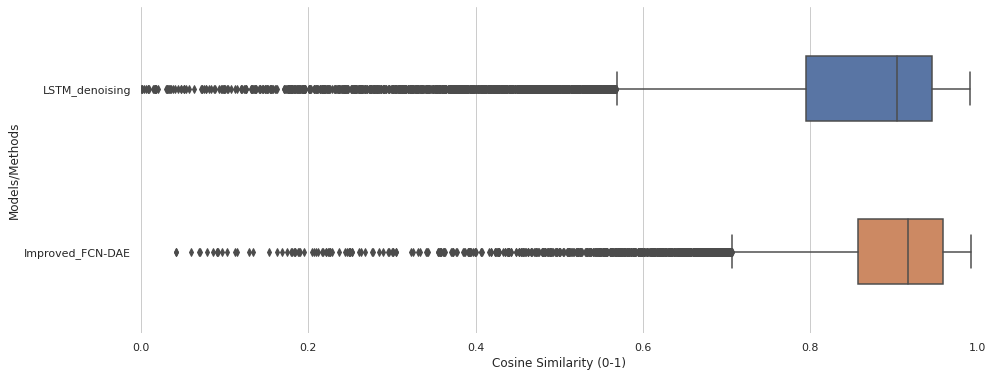

In [ ]:
# Metrics graphs
print('SSD Metric comparative graph')
generate_hboxplot(SSD_all, Exp_names, 'SSD (au)', log=False, set_x_axis_size=(0, 100.1))
print('MAD Metric comparative graph')
generate_hboxplot(MAD_all, Exp_names, 'MAD (au)', log=False, set_x_axis_size=(0, 3.01))
print('PRD Metric comparative graph')
generate_hboxplot(PRD_all, Exp_names, 'PRD (au)', log=False, set_x_axis_size=(0, 150.1))
print('Cosine Similarity Metric comparative graph')
generate_hboxplot(CORR_all, Exp_names, 'Cosine Similarity (0-1)', log=False, set_x_axis_size=(0, 1))

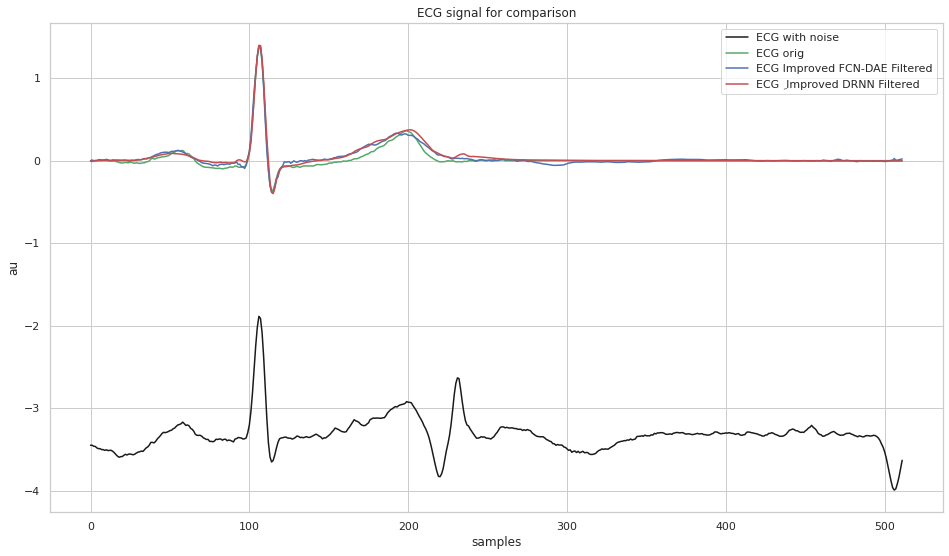

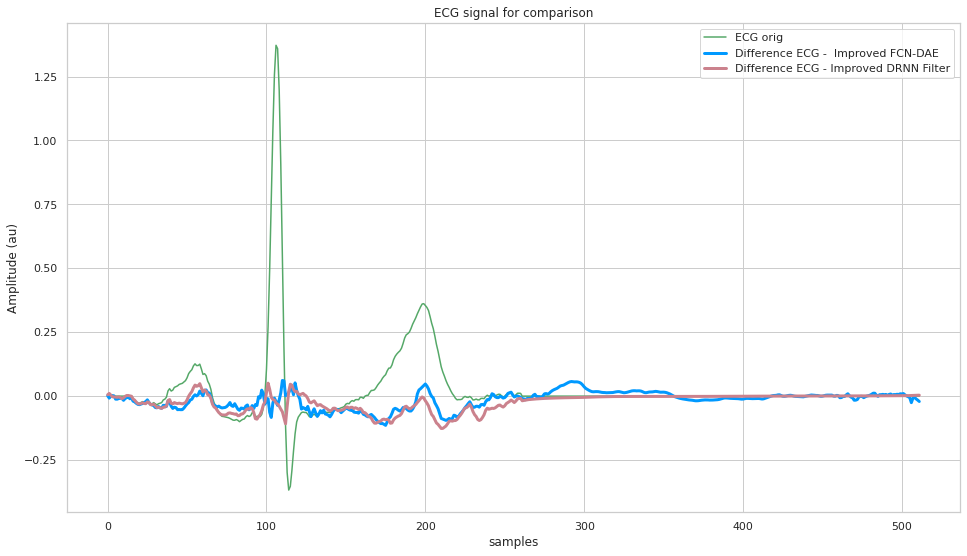

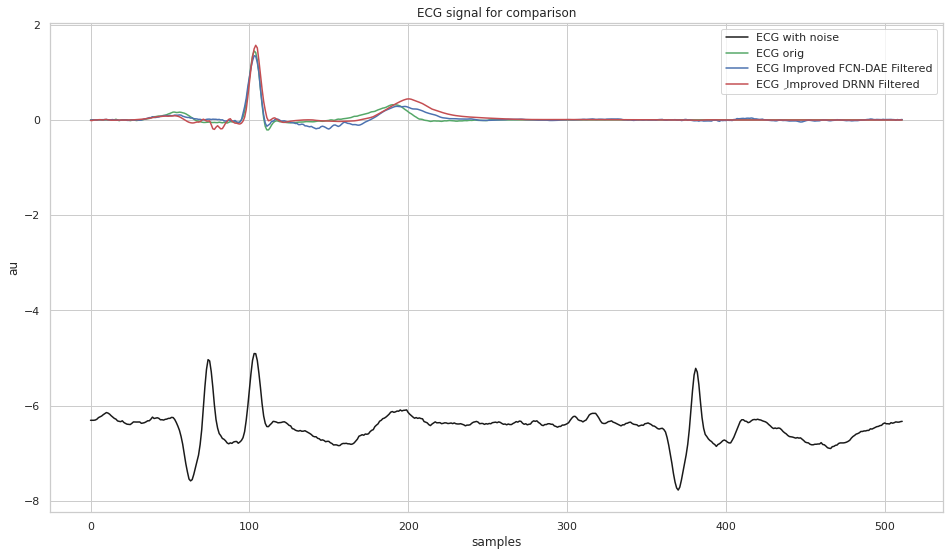

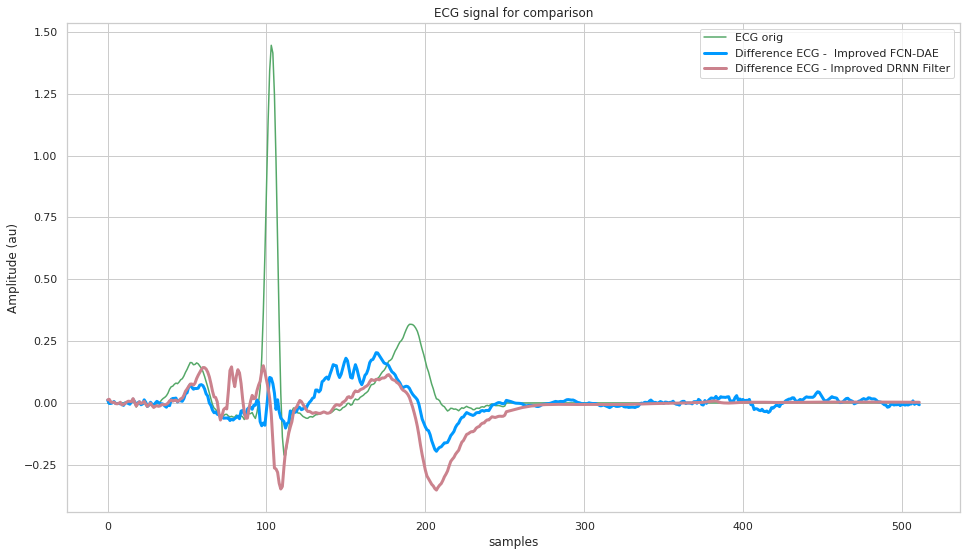

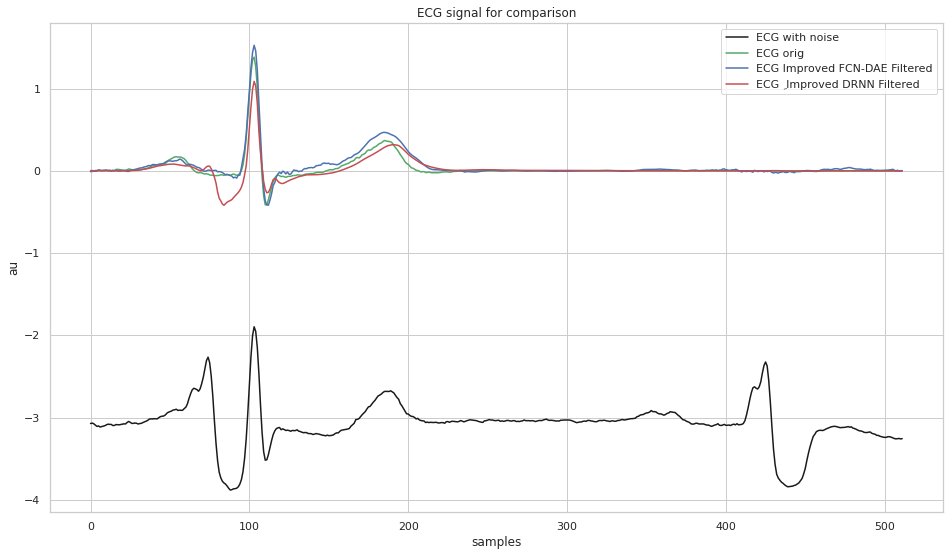

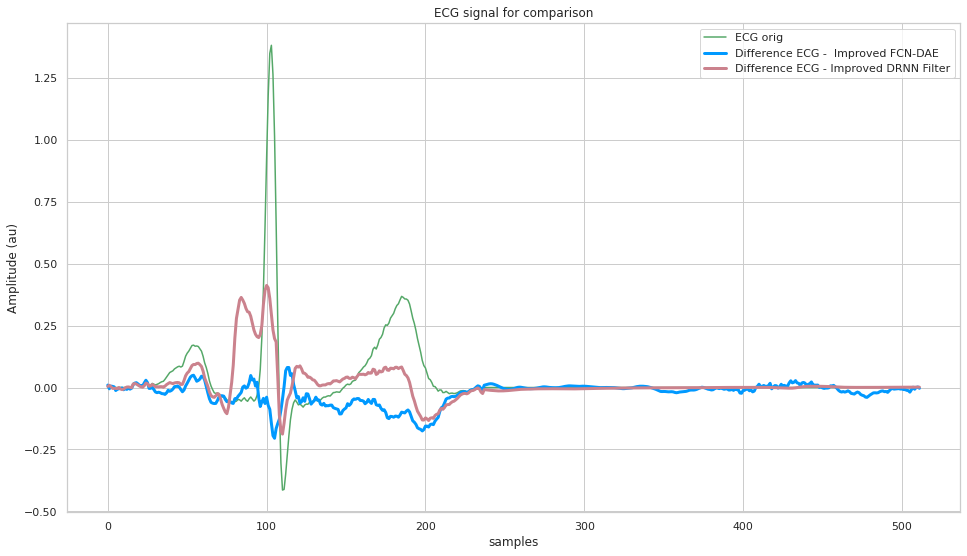

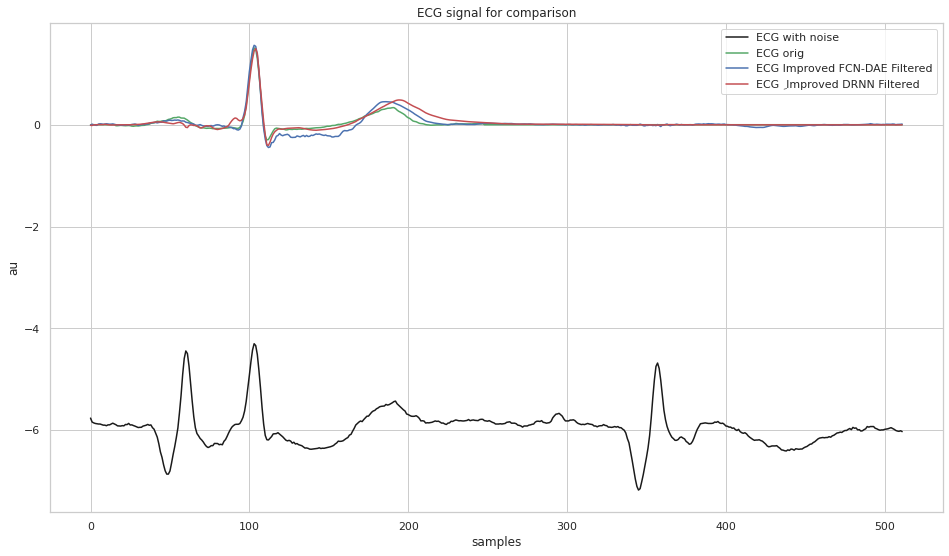

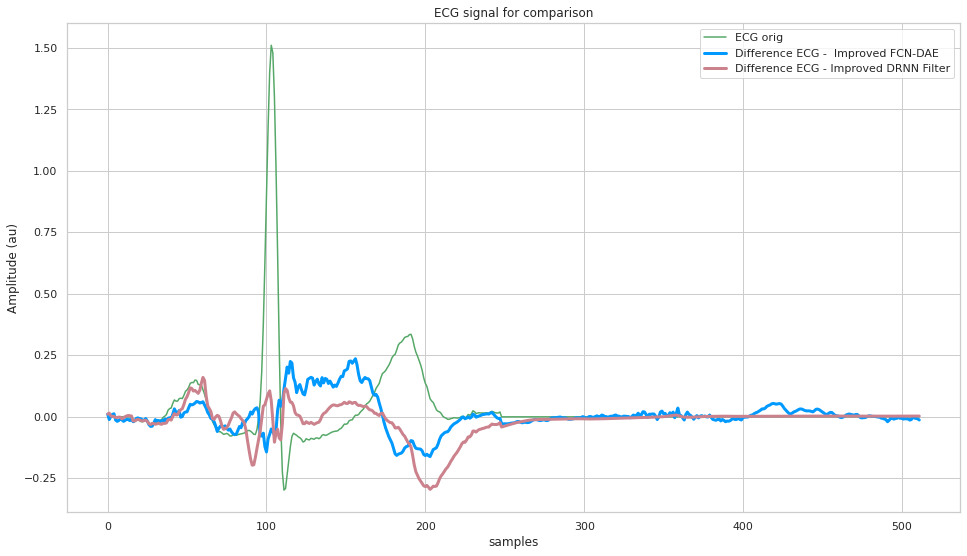

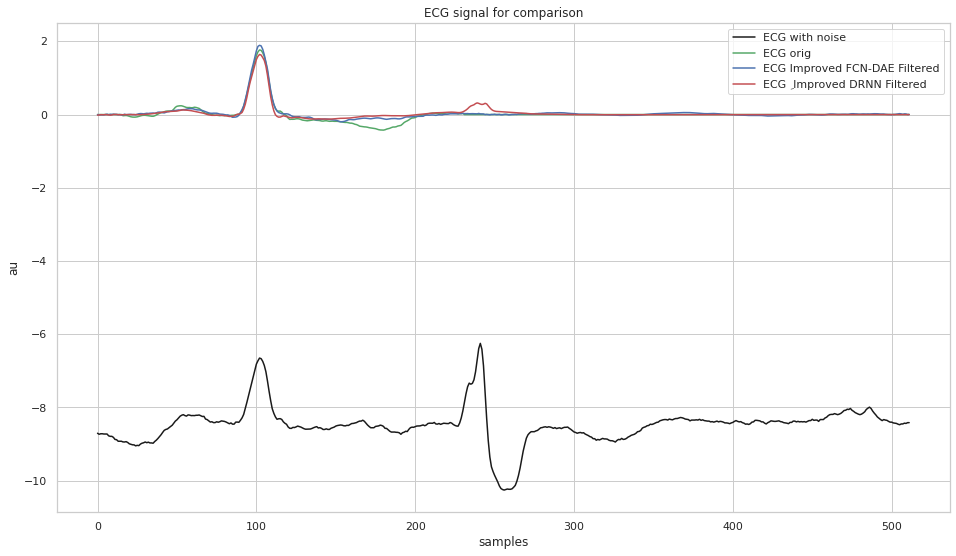

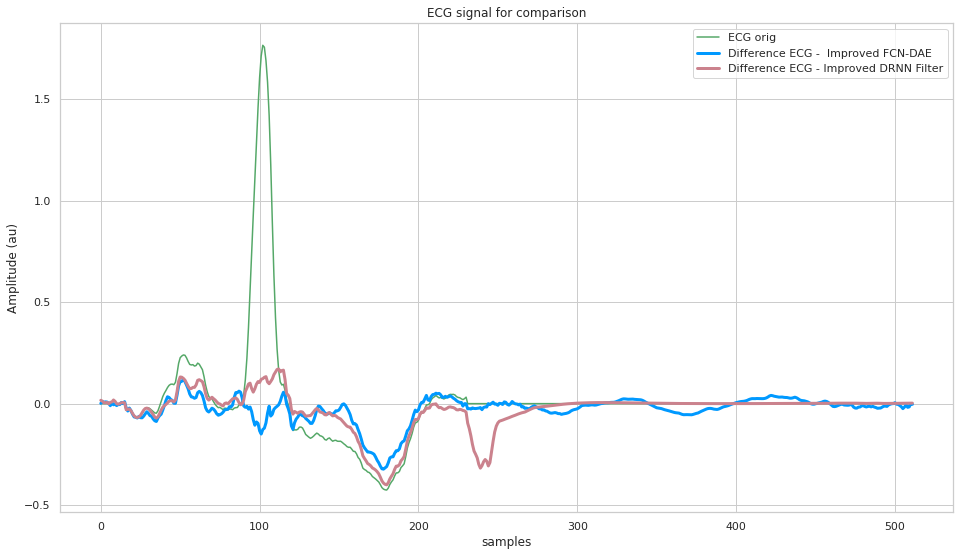

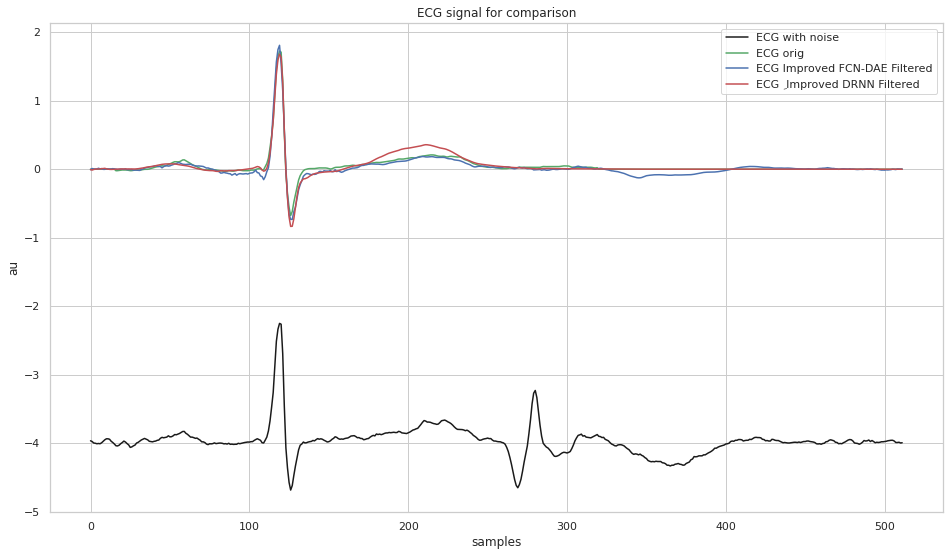

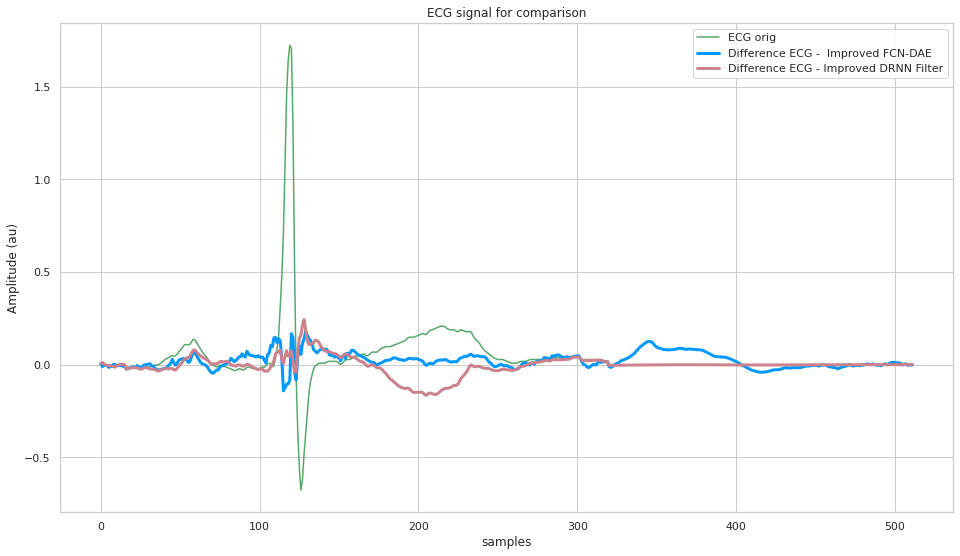

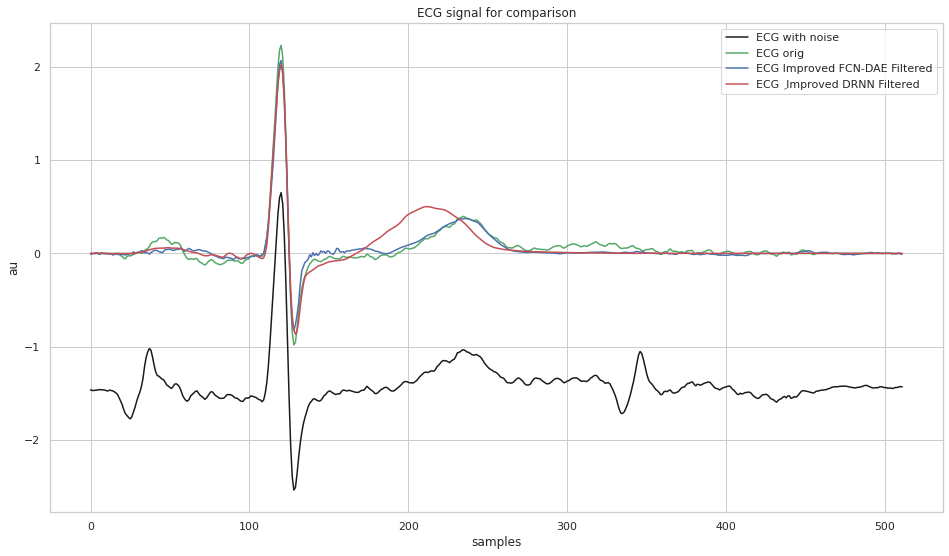

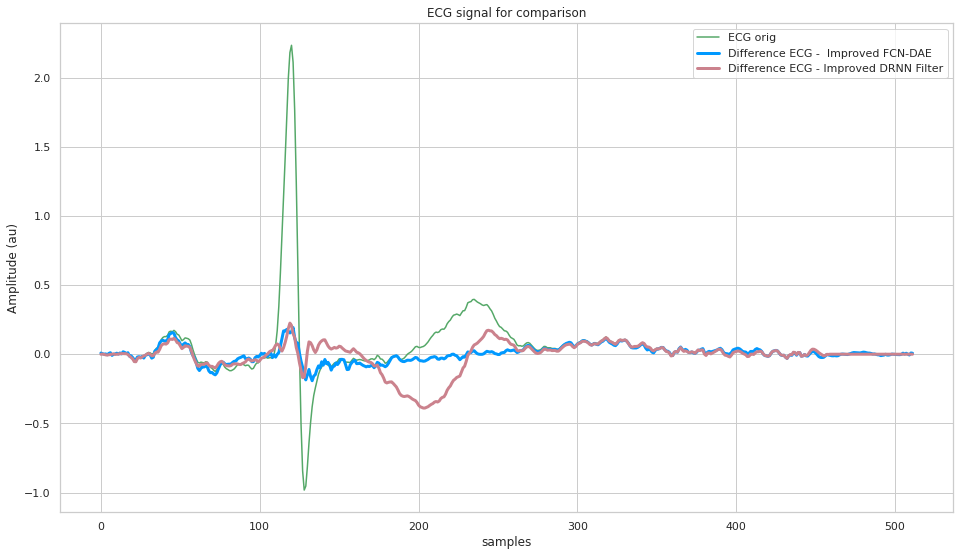

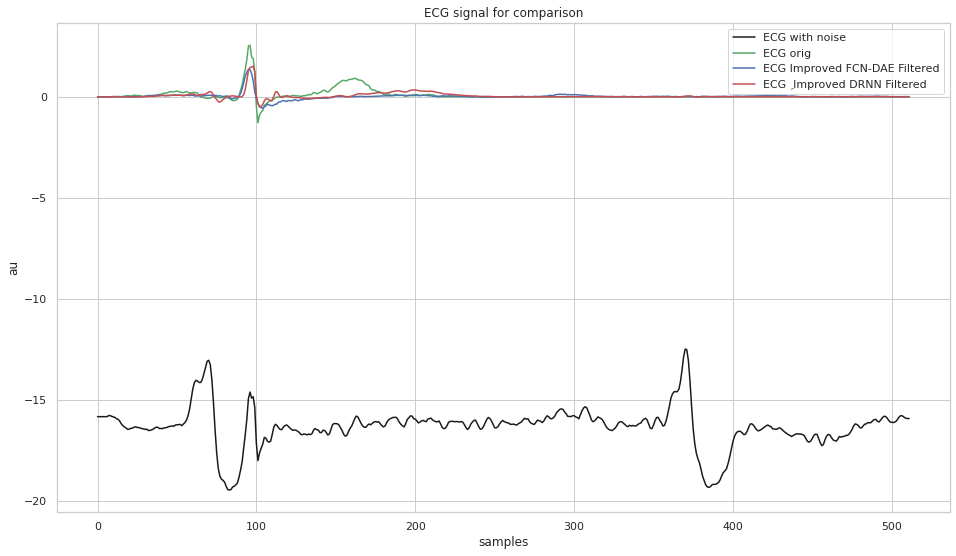

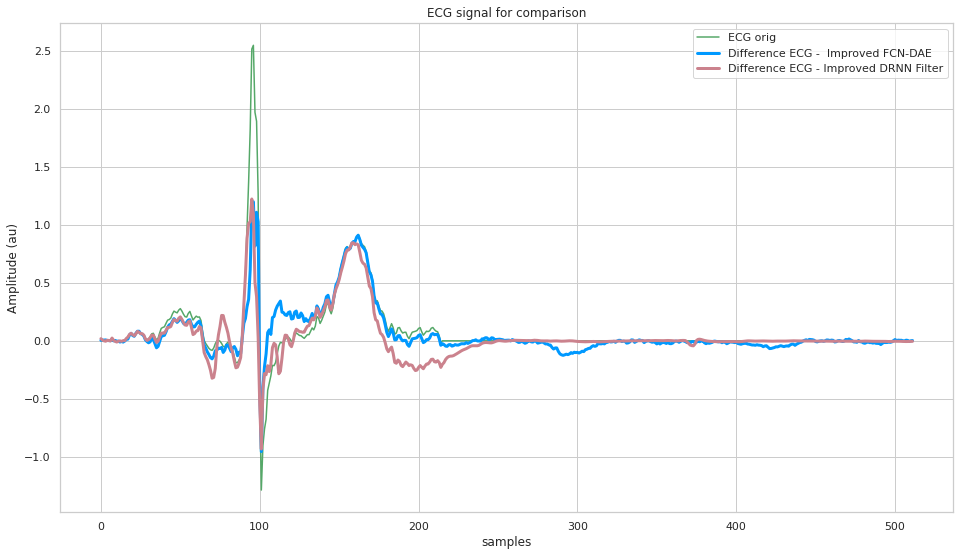

In [ ]:
# Visualize signals

signals_index = np.array([110, 210, 410, 810, 1610, 3210, 6410, 12810]) + 60

ecg_signals2plot = []
ecgbl_signals2plot = []
dl_signals2plot = []
fil_signals2plot = []

signal_amount = 10

[X_test, y_test, y_pred] = test_Improved_FCN_DAE  
for id in signals_index:
    ecgbl_signals2plot.append(X_test[id])
    ecg_signals2plot.append(y_test[id])
    dl_signals2plot.append(y_pred[id])

[X_test, y_test, y_pred] = test_LSTM_denoising   
for id in signals_index:
    fil_signals2plot.append(y_pred[id])

for i in range(len(signals_index)):
    ecg_view(ecg=ecg_signals2plot[i],
             ecg_blw=ecgbl_signals2plot[i],
             ecg_dl=dl_signals2plot[i],
             ecg_f=fil_signals2plot[i],
             signal_name=None,
             beat_no=None)

    ecg_view_diff(ecg=ecg_signals2plot[i],
                  ecg_blw=ecgbl_signals2plot[i],
                  ecg_dl=dl_signals2plot[i],
                  ecg_f=fil_signals2plot[i],
                  signal_name=None,
                  beat_no=None)

In [ ]:
[]